# Workflow to calculate the quantum efficiency of a polycrystalline material

In [1]:
import subprocess
import numpy as np
import os

from ase.calculators.castep import Castep
from ase.atoms import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.ext.matproj import MPRester
from pymatgen.core import Lattice,  Molecule
from pymatgen.core.structure import Structure
from pymatgen.core.surface import SlabGenerator, generate_all_slabs
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.wulff import WulffShape
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine, BandStructure
from pymatgen.electronic_structure.core import Spin
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro,KPathSeek
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.analysis.eos import EOS
from python_functions import *
from bs_plotting import *
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
directory = './structures/Cu_surf_111/'
work_fct = 3.52958434
listOfFiles = os.listdir(directory)
for item in listOfFiles:
    if '_photo.odi' in item:
        subprocess.call(f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}',shell=True)
#subprocess.call(,)
#f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}'
#f'sed -i "s/.*slab_volume.*/slab_volume : {round(slab_vol,5)}/" {path}{item}'

In [ ]:
cell = read_cell2pmg('./structures/Cu_surf_111_bak/Cu_surf_111_geom.cell')
#cell = CastepOutput('./structures/Cu_surf_111/Cu_surf_111.castep').structure
print(cell)

In [ ]:
view(AseAtomsAdaptor.get_atoms(cell))

In [ ]:
file_path = './structures/Cu_surf_111_photo/Cu_surf_111.castep'
output = CastepOutput(file_path)#
print(output.structure)

In [ ]:
seed = 'Cu_bulk_spectral_pdos'
seed = 'Cu_surf_111'
eins, axis = plot_proj_dos_optados(seed, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.savefig('Cu111_pdos_-10_10.png',dpi=200)

In [ ]:
struct_110 = AseAtomsAdaptor.get_structure(read('./structures/Cu_surf_110/Cu_surf_110.xyz'))
latimer = KPathLatimerMunro(struct_110)
for index in range(12):
    print('Latimer_Munroe Label:', latimer.LabelSymbol(index),'Point: ', latimer.LabelPoints(index))
print('SetyawanCurtarolo/ASE',KPathSetyawanCurtarolo(struct_110).orc())

I recommend using pymatgen to generate the bulk/slab and then convert it to an ASE atom object. The advantages of this approach are:
- pymatgen has a better bulk/slab generation algorithm 
- castep can link a calculator to the Atom object


#### Download and save .cif file for necessary materials

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
# print(bulk)
# print(bulk.volume)
# print(bulk.lattice)
# print(bulk.species)
# print(bulk.sites)
bulk_ase = AseAtomsAdaptor().get_atoms(bulk)
# print(bulk_ase)
# print(bulk)
surface = ase.build.surface(lattice = bulk_ase, indices = (1,1,1), layers = 5, vacuum=15, tol=1e-10, periodic=True)
print(get_adjusted_kpts(bulk,AseAtomsAdaptor.get_structure(surface), [9,9,9] ))
view.add_unitcell()
view

In [ ]:
surf_110 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_110.cell')
view(AseAtomsAdaptor.get_atoms(surf_110))
surf_100 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_100.cell')
view(AseAtomsAdaptor.get_atoms(surf_100))

#### Read the Cutoff Energy Results and Display as Graph

In [ ]:
seeds = ['Cu_bulk_200','Cu_bulk_300','Cu_bulk_400','Cu_bulk_500', 'Cu_bulk_550','Cu_bulk_600']
cutoffs = [300,400,500,550,600]
tot_energies = []
differences = []
for seed in seeds:
    temp_out = CastepOutput(path = f'./structures/cutoff_convergence/{seed}.castep')
    tot_energies.append(temp_out.ks_total_energy) 
for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences.append(abs(tot_energies[i+1]-tot_energies[i]))
print('Differences:', differences)
print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
graph = sns.lineplot(x=cutoffs, y=differences)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'energy cutoff [eV]', ylabel = r'$\Delta E_{tot}$', title = 'Energy Cutoff Convergence')
graph.set(xlim = (390,610), ylim =  (-0.1,1.1))
plt.legend(labels=[r'$\Delta$s',r'$\frac{1}{2}kT$'])


#### Create scaled volume inputs, read the output files and create murnaghan plot

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
create_murnaghan_inputs(seed = 'Cu_bulk_murn', structure=bulk, cutoff = 600, kpoints=[16,16,16], min_max=(0.9,1.1,10))

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')
#plt.savefig(f'./structures/plots/{seed}_pbesol.png')

#### Read the Results for Kpoint grid convergence and plot as graph

ToDo: Modify the Kpoint convergence generation function to make a single input and then vary the values within the PBS script

In [ ]:
seeds = ['Cu_bulk_2','Cu_bulk_4','Cu_bulk_6','Cu_bulk_8','Cu_bulk_9','Cu_bulk_10','Cu_bulk_12','Cu_bulk_14','Cu_bulk_16','Cu_bulk_18']
tot_energies = []
differences = []
kpoints = [4,6,8,9,10,12,14,16,18]
kpoints2 = kpoints[1:]
for seed in seeds:
    temp_out = CastepOutput(path = f'./structures/kpt_convergence/{seed}.castep')
    tot_energies.append(temp_out.ks_total_energy)
for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences.append(abs(tot_energies[i+1]-tot_energies[i]))
sns.set_theme(style="darkgrid")
differences_2 = differences[1:]
#print(differences_2)
# Plot the responses for different events and regions
graph = sns.lineplot(x=kpoints2, y=differences_2)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'MP k-point grid size (x,x,x)', ylabel = r'$\Delta E_{tot}$ [eV]', title = 'K-point Grid Convergence')
plt.legend(labels=[r'$\Delta$ E',r'$\frac{1}{2}kT$'])
#plt.savefig('./structures/plots/k_point_convergence_zoom.png',dpi = 300)

#### Read in the geometry optimisation trajectory file

In [ ]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

data = read_geometry_traj_file(path = './structures/')

#### Plot the electronic densities and potential

Writing volume= 188.874616 A^3 and area= 6.33974 A^2 to Cu_surf_100_photo.odi


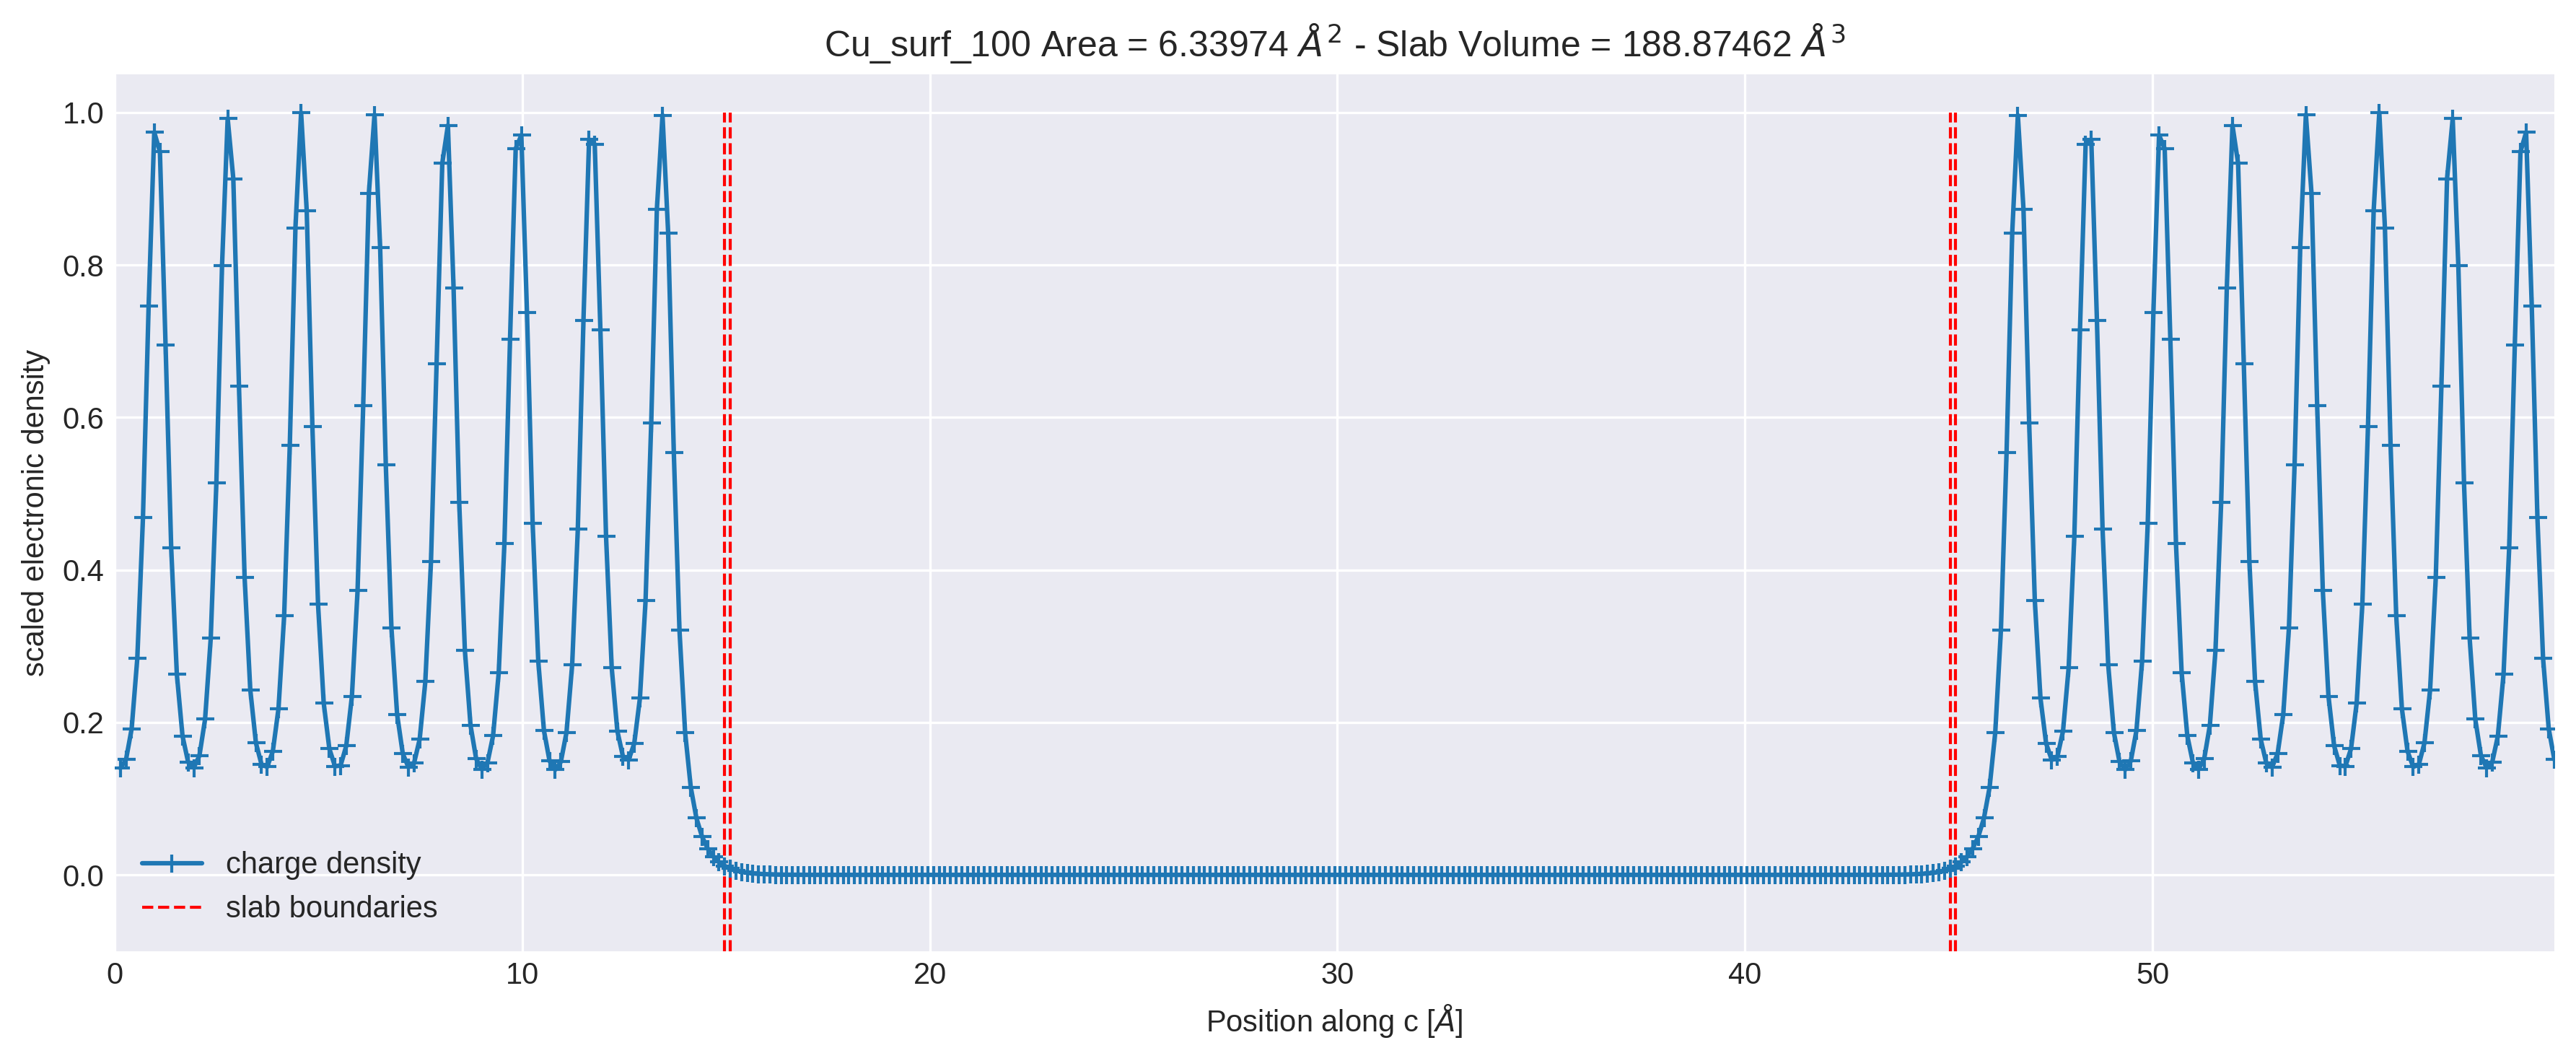

In [2]:
fig,ax = create_density_plot(directory = './structures/Cu_surf_100_victor_60A/', centered = False)
plt.tight_layout()
plt.savefig('./structures/plots/Cu100_victor_60A_density_plot.png')

Writing work_function= 4.54751 eV to Cu_surf_100_photo.odi


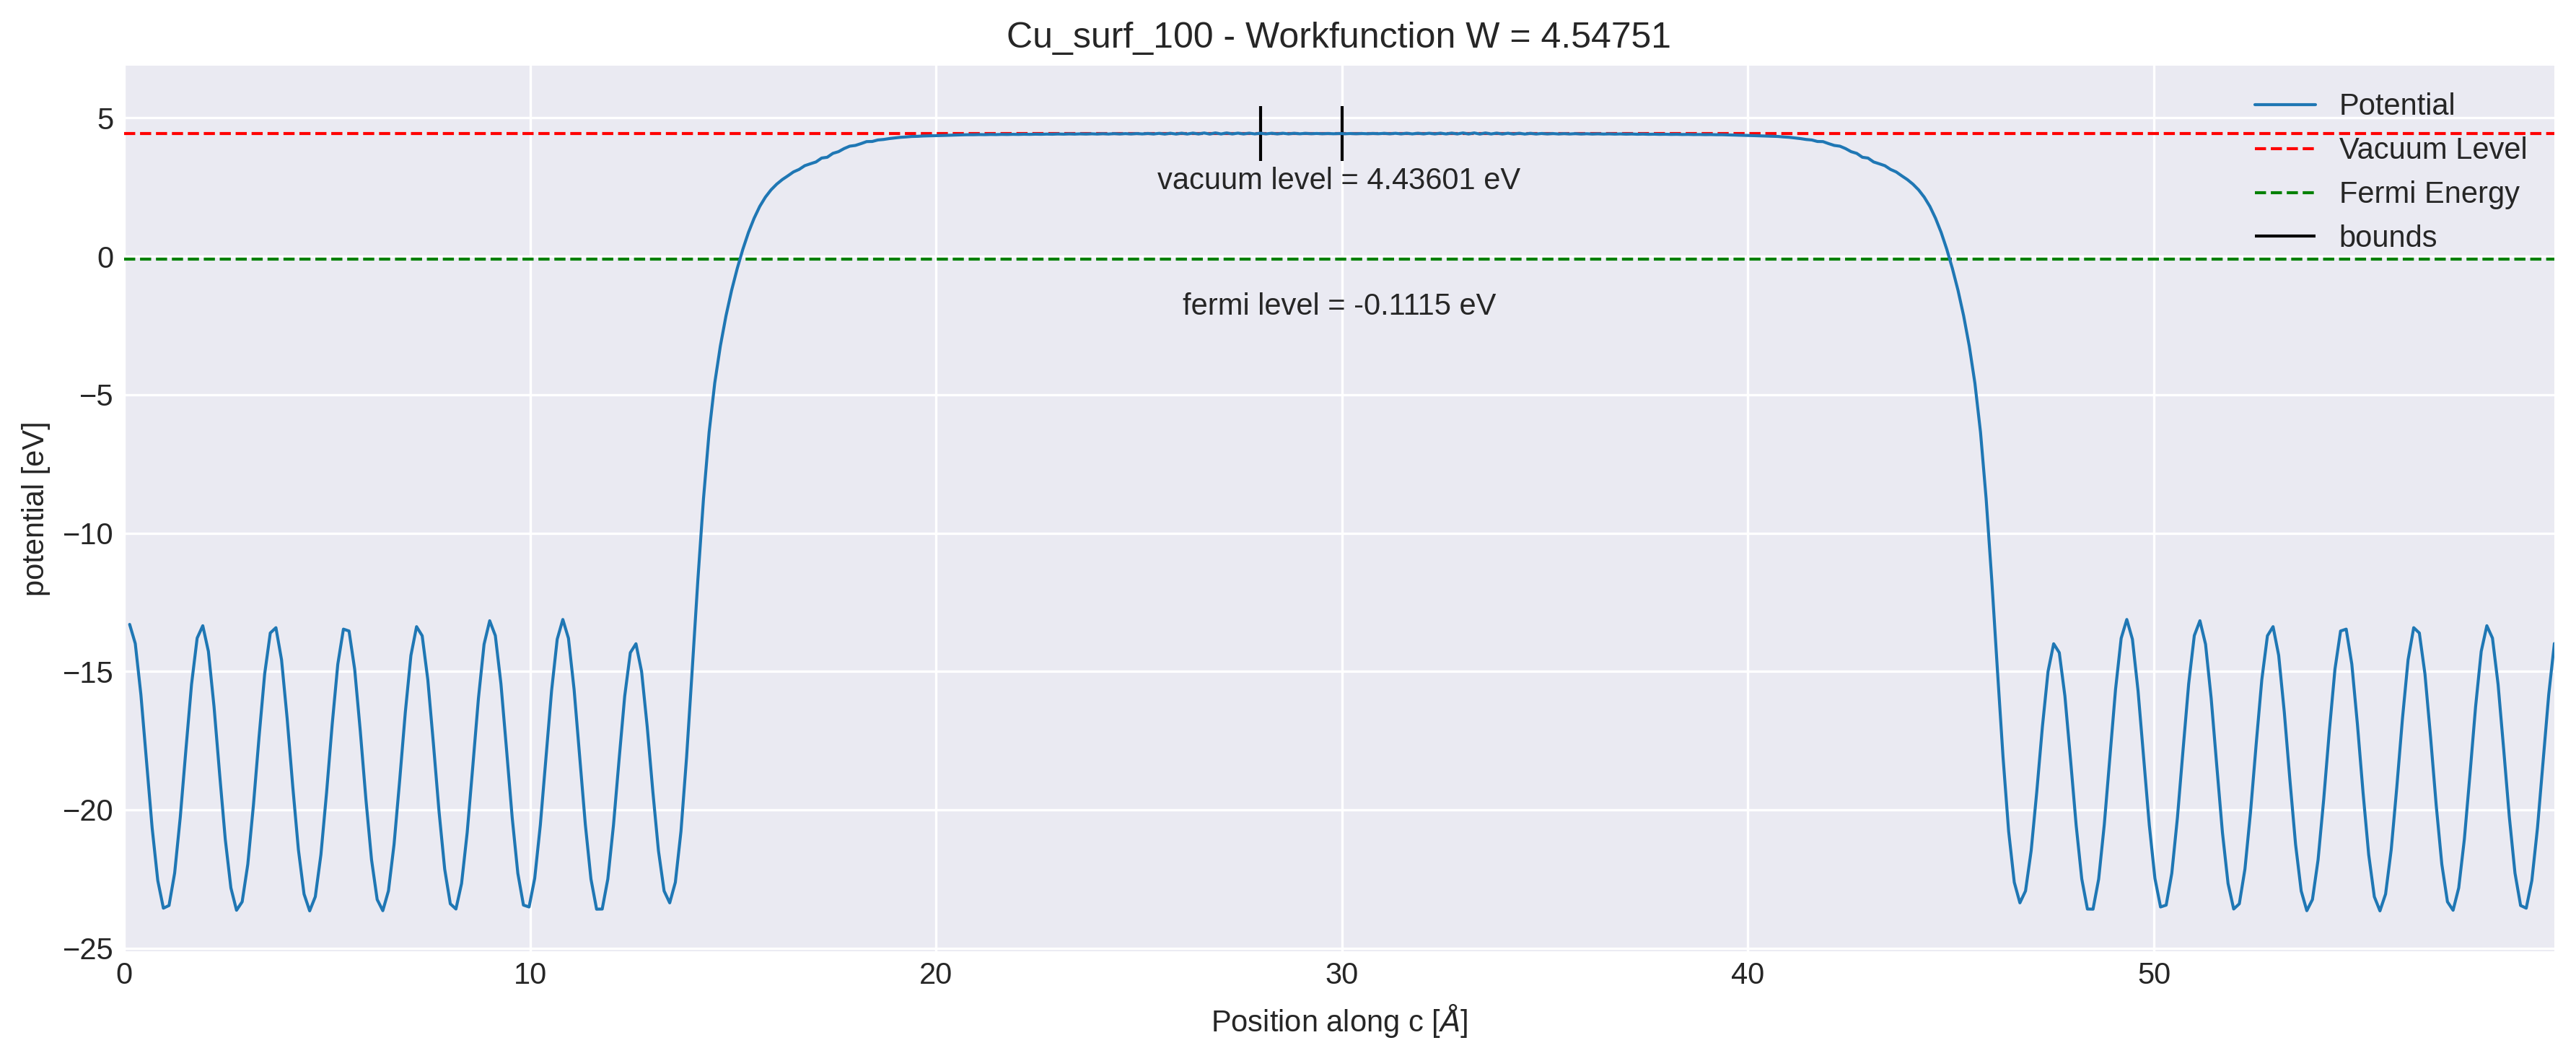

In [3]:
fig,ax = create_potential_plot(directory='./structures/Cu_surf_100_victor_60A/', centered = False)
plt.tight_layout()
plt.savefig(f'./structures/plots/Cu100_victor_60A_potential_plot.png')

#### Create Plot with modified pymatgen functions to create more colourful bandstructure plot

In [ ]:
#%matplotlib inline
bandstructure_cu = read_bands2pmg('Cu_surf_111', export=False)
#print(bandstructure_cu.distance)
output = []
for kpt in bandstructure_cu.kpoints:
    output.append((kpt.label,kpt.cart_coords))
plot = get_bs_plot(bandstructure_cu,ylim = (-10,10))

plt.savefig('./structures/plots/Cu_bandstruct_120deg_ooriginal.png')

#### Plot reference Cu Bandstructure from Materials Project 

In [ ]:
with open('./structures/band_jsons/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_new = BandStructureSymmLine.from_dict(d)

plotter = BSPlotter(bandstruct_new)
#print(bandstruct_new.as_dict()['branches'])
#print(bandstruct_new.get_branch(320))
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

#### Plot bandstructure from castep .bands file using ASE functions

In [ ]:
#bandfile = create_bands_file(calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Fe_metal_bcc.cif")),seed = 'Fe')
seed = 'Cu_bulk_bandstruct'
calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Cu_metal_fcc.cif"))
calc = ase.calculators.castep.Castep(check_castep_version = False,keyword_tolerance=3)
calc_struct.calc = calc
bandstructure = calc_struct.calc.band_structure(bandfile=f'./structures/{seed}/{seed}.bands').subtract_reference()
#print(bandstructure.get_labels())
plt.style.use('seaborn')
#ax.ylimit(-12,35)
bandstructure.plot(emin=-12, emax=35)

#### Create Parameter Sweep for OptaDOS

In [2]:
photoemission_options= {
        'work_function' : 4.3731,
        'surface_area' : 6.55677,
        'slab_volume' : 198.13882,
        'elec_field' : 0,
        'optics_qdir' : [1, 1.000, 1.0000],
        'photo_model' : ['1step','3step'] # 1step or 3step or 1step,3step
}
optados_photon_energy_sweep(seed='Cu_surf_110', min_max = (4,5.5,20), **photoemission_options)

In [4]:
one = [1,2,3,4]
print(' '.join([str(x) for x in one]))

1 2 3 4


#### Read in the photon energy sweep output files

In [ ]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_111', path = './structures/Cu_surf_111/test_01/')
graph_options = {
    'title': 'Cu[111]',
    'temperature': 298,
    'filename' : './structures/plots/Cu_111_pbesol_120deg_test1_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

In [ ]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_111', path = './structures/Cu_surf_111/')
graph_options = {
    'title': 'Cu[111]',
    'temperature': 298,
    'filename' : './structures/plots/Cu_111_pbesol_120deg_test2_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

### Plot DOS plot created by OptaDOS

In [ ]:
seed = 'Cu_surf_111'
fig, ax= plot_dos_optados(seed, plot_total = False, xlimit = (-12, 35), export_json = False)
#plt.savefig(f"./structures/plots/{seed}_dos.png")

### Plot proj DOS plot created by OptaDOS

In [ ]:
#seed = 'Cu_bulk_spectral_pdos'
seed = 'Cu_surf_111'
eins, axis = plot_proj_dos_optados(seed, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.tight_layout()
plt.savefig('./structures/plots/Cu111_120deg_-10_10.png',dpi=200)

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_spectral_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
plotter.get_plot(xlim = (-12,2.5),ylim=(-0.2,9))
plt.savefig('./structures/plots/Cu_bulk_tot_dos_comparison_dos_matproj_zoom.png')

In [ ]:
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_full = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full_UX.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_ux = BandStructureSymmLine.from_dict(d)
bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
    json.dump(bandstruct_full.as_dict(), f)
plotter = BSPlotter(bandstruct_full)
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_ref = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/cu_bandstruct_all_points.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_full = BandStructureSymmLine.from_dict(d)

#bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
#with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
#    json.dump(bandstruct_full.as_dict(), f)

plotter = BSPlotter(bandstruct_cu_full)
plotter.add_bs(bandstruct_cu_ref)
band_plot = plotter.get_plot(ylim=(-12,35), bs_labels=['Calculated','Materials Project Ref'])
plt.xlabel('')
plt.savefig('comparison_calculated_vs_matproj_ref_optados_Efermi.png')
band_plot.show()
